In [ ]:
#Import packages

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
#Read data

train = pd.read_csv('train.csv', index_col = 0)
test = pd.read_csv('test.csv', index_col = 0)

#set features and target

x_train1 = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

train.shape

(1460, 80)

In [3]:
#Define continuous and categorical variables

cont =['LotFrontage', 'LotArea', 'MasVnrArea', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath']

cat = list(set(x_train1.columns) - set(cont))

#make sure categorical vars are strings
x_train1[cat] = x_train1[cat].astype(str)
test[cat] = test[cat].astype(str)

#Encode categorical

le = LabelEncoder()

x_train2= pd.DataFrame()
test2= pd.DataFrame() #For use later

for i in cat:
    x_train2[i] = le.fit_transform(x_train1[i])
    test2[i] = le.fit_transform(test[i])

#merge encoded and continuous variables
x_train2 = np.concatenate((x_train2, x_train1[cont]), axis=1)
test2 = np.concatenate((test2, test[cont]), axis=1)

columnNames  = cat + cont
x_train2 = pd.DataFrame(x_train2, columns = columnNames)
test2 = pd.DataFrame(test2, columns = columnNames)

#Remove NaN with 0
x_train2.fillna(0, inplace=True)
test2.fillna(0, inplace=True)

0.8410659155298942
0.8381266757874085


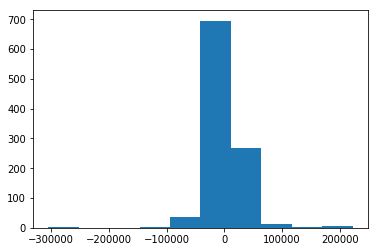

In [4]:
#get R^2 with multiple linear
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(x_train2, y_train, test_size=0.3, random_state=42)

lm = LinearRegression()
lm.fit(X_train_cv, y_train_cv)
residuals = y_train_cv - lm.predict(X_train_cv)
plt.hist(residuals)

print(lm.score(X_train_cv, y_train_cv)) #0.841
print(lm.score(X_test_cv, y_test_cv)) #0.838, slight under fitting?

In [5]:
#multicollinearity among vars
#lm.score(X_train_cv, y_train_cv) #0.841

scores = {}
ols = LinearRegression()
from sklearn.metrics import r2_score

for i in X_train_cv.columns:
    df = X_train_cv.copy()
    feature = df[i].copy()
    df.drop(i, axis = 1, inplace = True)
    ols.fit(df, feature)
    scores[i] = ols.score(df, feature)

Text(0.5, 1.0, '$R^2$ of a continuous feature against the other features')

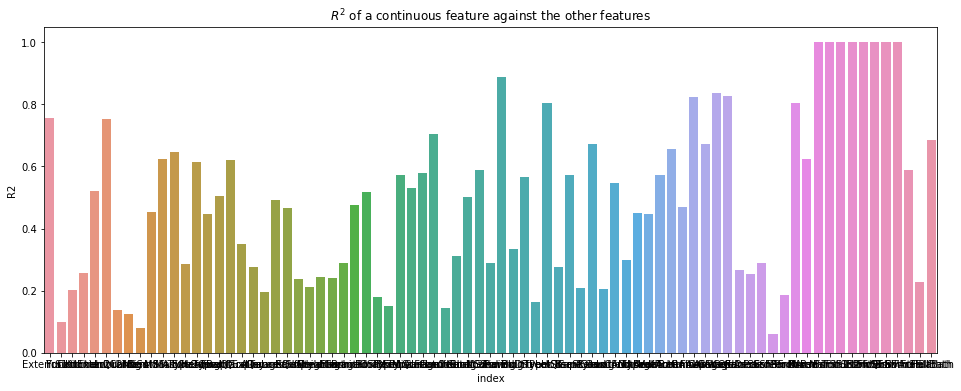

In [8]:
#visualize how each var is related to each other
plt.figure(figsize=(16, 6))
sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of a continuous feature against the other features')


In [9]:
#take note of vars with R^2 < 0.5
features = [k for k, v in scores.items() if v < 0.5]
relevant_features1 = X_train_cv[features]
len(relevant_features1.columns)

40

In [10]:
#look at multicollinearity with VIF

vif = {'factor': [], 'features': []}

for i in range(X_train_cv.shape[1]):
    factor = variance_inflation_factor(X_train_cv.values, i)
    
    if factor <= 5:
        vif['factor'].append(factor)
        vif['features'].append(X_train_cv.columns[i])
        
relevant_features2 = X_train_cv[vif['features']]

len(relevant_features2.columns)


/home/sofiawangy/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


19

In [11]:
#Get R^2 with non redundant vars from VIF above
# 1. with first features
lm2 = LinearRegression()
lm2.fit(relevant_features1, y_train_cv)
print(lm2.score(relevant_features1, y_train_cv)) #0.581, pretty low
print(lm2.score(X_test_cv[features], y_test_cv)) #0.611, over fitting


0.5806548906778816
0.6118490813151013


In [12]:
# 2. with second features
lm2.fit(relevant_features2, y_train_cv)
print(lm2.score(relevant_features2, y_train_cv)) #0.502
print(lm2.score(X_test_cv[relevant_features2.columns], y_test_cv)) #0.507, even lower


0.5020978863665992
0.5075742327235158


In [13]:
#Check mulitcollinearity with ANOVA

x = sm.add_constant(x_train2)
results = sm.OLS(list(y_train), x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     98.80
Date:                Fri, 24 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:59:40   Log-Likelihood:                -17177.
No. Observations:                1460   AIC:                         3.451e+04
Df Residuals:                    1382   BIC:                         3.492e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.511e+05   4.85e+04      5.177

/home/sofiawangy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [47]:
pValues = results.pvalues
pValues = list(pValues[pValues<0.05].index)
relevant_features3 = X_train_cv.loc[:, pValues[1:]]

In [48]:
lm2.fit(relevant_features3, y_train_cv)
print(lm2.score(relevant_features3, y_train_cv)) #0.83
print(lm2.score(X_test_cv[relevant_features3.columns], y_test_cv)) #0.841, better than other methods

0.8305956026943301
0.8414619293400437


In [ ]:
#elasticnet


In [ ]:
#random forest

In [ ]:
#gradient boosting